# Primera parte: Clasificación de textos

En esta parte, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).




In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

reuters = keras.datasets.reuters

VOCAB_SIZE = 10000

#11228 noticias en total
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=VOCAB_SIZE)
print("Training entries: {}, Test entries: {}".format(len(train_data), len(test_data)))

# Tamaños de los textos para determinar longitud de las secuencias a usar
lengths = [len(x) for x in train_data]
print("Average length es {}".format(np.mean(lengths)))
print("Max length es {}".format(max(lengths)))
print("Median length es {}".format(np.percentile(lengths, 50)))

SEQUENCE_LENGTH = 150

2113536/2110848 [==============================] - 1s 1us/step
Training entries: 8982, Test entries: 2246
Average length es 145.5398574927633
Max length es 2376
Median length es 95.0


In [3]:
#Un diccionario que asigna palabras a un índice entero.
word_index = reuters.get_word_index()

#Los primeros índices son reservados. 
#Asignamos un valor para inicio de cadena, stra. A nuestro word index le estamos añadiendo estos tokens especiales

word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0 
word_index["<START>"] = 1 
word_index["<UNK>"] = 2 #No conocido
word_index["<UNUSED>"] = 3

#Si sabemos un índice podemos saber la palabra. 

reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

def decode_review(text):
    return ''.join([reverse_word_index.get(i, '?') for i in text])

557056/550378 [==============================] - 1s 1us/step


In [5]:
decode_review(train_data[1])

'<START>generaledebanquesalt<UNK>brandlthelleroverseascorpofchicagohaveeachtaken50pctstakesin<UNK>companysa<UNK>factorsgeneraledebanquesaidinastatementitgavenofinancialdetailsofthetransactionsa<UNK><UNK>turnoverin1986was175billionbelgianfrancsreuter3'

In [20]:
print(len(train_data))

8982


In [24]:
tamanos = [len(train_data[x]) for x in range(len(train_data))]

In [39]:
import statistics as st
print("media : ", st.mean(tamanos), "\nDesvisacion standar : ", st.stdev(tamanos),"\nValor maximo : ",max(tamanos), "\nValor minimo :" , min(tamanos))
print("intervalo confizanza u + 1std  (68.27 %) ", st.mean(tamanos) + st.stdev(tamanos))
print("intervalo confizanza u + 2std  (95.45 %) ", st.mean(tamanos) + 2*st.stdev(tamanos))
print("intervalo confizanza u + 3std  (99.73 %) ", st.mean(tamanos) + 3*st.stdev(tamanos))

media :  145.5398574927633 
Desvisacion standar :  145.82224783097502 
Valor maximo :  2376 
Valor minimo : 13
intervalo confizanza u + 1std  (68.27 %)  291.3621053237383
intervalo confizanza u + 2std  (95.45 %)  437.18435315471334
intervalo confizanza u + 3std  (99.73 %)  583.0066009856884


En base a la regla empirica, observando el histograma de distribucion de las longitudes de las secuencias de los textos, he decidio por optar utilizar una ventana de valor :

1 media + 2 desviciaciones Standar = 145.82+ 2* 145*8224 = 437

In [40]:
train_data = keras.preprocessing. sequence.pad_sequences(train_data, 
                                                        value=word_index["<PAD>"], 
                                                        padding='post', 
                                                        maxlen=437)

test_data = keras.preprocessing. sequence.pad_sequences(test_data, 
                                                        value=word_index["<PAD>"], 
                                                        padding='post', 
                                                        maxlen=437)

In [49]:
print(len(train_data[0]), len(train_data[2]))

437 437
4


In [197]:
train_data.shape

(8982, 437)

In [54]:
train_labels.max()
test_labels.max()

45

In [156]:
#la forma de entrada es el recuento de vocabulario utilizado para las reseñas de películas
vocab_size = 50000

model = keras.Sequential()
#una capa de embedding de los 10000 que tenemos en el vocabulario con un tamaño de 16. 
#Por cada elemento de entrada nos de un word embedding de 16 elementos. 
#256 vectores de 16 elementos 

model.add(keras.layers.Embedding(vocab_size,32)) 
#Como son muchos elementos vamos a crear la medio de los word_embeddings
model.add(keras.layers.GlobalAveragePooling1D())
#Ahora si, una capa densa con relu
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
#Una última capa que tiene 1 elemento. La sigmoid se identifica más con una probabilidad.
model.add(keras.layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 32)          1600000   
_________________________________________________________________
global_average_pooling1d_18  (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_35 (Dense)             (None, 46)                782       
Total params: 1,601,310
Trainable params: 1,601,310
Non-trainable params: 0
_________________________________________________________________


In [157]:
model.compile(optimizer='adam', 
             loss='sparse_categorical_crossentropy', #la misma función de pérdida que CategoricalCrossentropy pero para problemas de dos clases
             metrics=['accuracy'])

In [158]:
x_val=train_data[:int(len(train_data)*0.8)] #datos de validación 
partial_x_train = train_data[int(len(train_data)*0.8):] 

y_val = train_labels[:int(len(train_data)*0.8)]
partial_y_train = train_labels[int(len(train_data)*0.8):]

In [159]:
int(len(train_data)*0.8)

7185

array([   1,   53,  147,   26,   14,  365,   26,   39,   32,  451,   18,
         14,   32,  251,   18,   86,   63,  315,   18,   14,   72,  639,
         18,  151,  230,   53,  948,   26,   14,  924,   26,   39,   59,
        980,   18,   14,   47,  698,   18,   86,  318,   72, 2128,   14,
        147,   12, 2128,   17,   12,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [160]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40, 
                   batch_size=64, 
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 1797 samples, validate on 7185 samples
Epoch 1/40
1797/1797 [==============================] - 2s 851us/sample - loss: 3.7967 - accuracy: 0.2922 - val_loss: 3.7495 - val_accuracy: 0.3534
Epoch 2/40
1797/1797 [==============================] - 1s 496us/sample - loss: 3.6824 - accuracy: 0.3450 - val_loss: 3.5861 - val_accuracy: 0.3534
Epoch 3/40
1797/1797 [==============================] - 1s 503us/sample - loss: 3.4441 - accuracy: 0.3450 - val_loss: 3.2394 - val_accuracy: 0.3534
Epoch 4/40
1797/1797 [==============================] - 1s 519us/sample - loss: 2.9834 - accuracy: 0.3450 - val_loss: 2.7000 - val_accuracy: 0.3534
Epoch 5/40
1797/1797 [==============================] - 1s 472us/sample - loss: 2.5063 - accuracy: 0.3450 - val_loss: 2.3978 - val_accuracy: 0.3534
Epoch 6/40
1797/1797 [==============================] - 1s 476us/sample - loss: 2.3548 - accuracy: 0.3450 - val_loss: 2.3577 - val_accuracy: 0.3534
Epoch 7/40
1797/1797 [==============================] - 1s 528us

In [161]:
results = model.evaluate(test_data, test_labels)
print(results)

2246/2246 [==============================] - 0s 57us/sample - loss: 1.7172 - accuracy: 0.5877
[1.7171732604450556, 0.5877115]


In [162]:
history_dict = history.history #A partir del objeto hystory lo guardamos para graficarlo
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

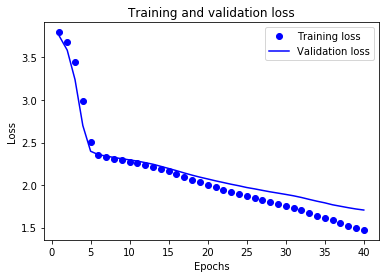

In [163]:
#%matplotlib inline

acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

#bo is for blue dot
plt.plot(epochs, loss, 'bo', label='Training loss')
#b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

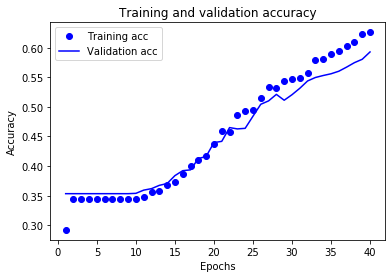

In [164]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

#bo is for blue dot
plt.plot(epochs, acc, 'bo', label='Training acc')
#b is for solid blue line
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [107]:
#la forma de entrada es el recuento de vocabulario utilizado para las reseñas de películas
vocab_size = 50000

model = keras.Sequential()
#una capa de embedding de los 10000 que tenemos en el vocabulario con un tamaño de 16. 
#Por cada elemento de entrada nos de un word embedding de 16 elementos. 
#256 vectores de 16 elementos 

model.add(keras.layers.Embedding(vocab_size, 32)) 
#Como son muchos elementos vamos a crear la medio de los word_embeddings

#Ahora si, una capa densa con relu
model.add(keras.layers.Conv1D(32, 3,activation='relu'))
model.add(keras.layers.Conv1D(32, 3,activation='relu'))
model.add(keras.layers.GlobalAveragePooling1D())

model.add(keras.layers.Dense(92, activation=tf.nn.relu))
#Una última capa que tiene 1 elemento. La sigmoid se identifica más con una probabilidad.
model.add(keras.layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          1600000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
global_average_pooling1d_8 ( (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 92)                3036      
_________________________________________________________________
dense_15 (Dense)             (None, 46)                4278      
Total params: 1,613,522
Trainable params: 1,613,522
Non-trainable params: 0
____________________________________________

In [108]:
model.compile(optimizer='adam', 
             loss='sparse_categorical_crossentropy', #la misma función de pérdida que CategoricalCrossentropy pero para problemas de dos clases
             metrics=['accuracy'])

In [111]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=25, 
                   batch_size=64, 
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 1797 samples, validate on 7185 samples
Epoch 1/25
1797/1797 [==============================] - 2s 967us/sample - loss: 2.2378 - accuracy: 0.3745 - val_loss: 2.2524 - val_accuracy: 0.3827
Epoch 2/25
1797/1797 [==============================] - 2s 957us/sample - loss: 2.1963 - accuracy: 0.3812 - val_loss: 2.2145 - val_accuracy: 0.3905
Epoch 3/25
1797/1797 [==============================] - 2s 1ms/sample - loss: 2.1467 - accuracy: 0.4085 - val_loss: 2.1761 - val_accuracy: 0.4090
Epoch 4/25
1797/1797 [==============================] - 2s 995us/sample - loss: 2.0898 - accuracy: 0.4240 - val_loss: 2.1346 - val_accuracy: 0.4507
Epoch 5/25
1797/1797 [==============================] - 2s 987us/sample - loss: 2.0292 - accuracy: 0.4763 - val_loss: 2.0902 - val_accuracy: 0.4527
Epoch 6/25
1797/1797 [==============================] - 2s 1ms/sample - loss: 1.9701 - accuracy: 0.4741 - val_loss: 2.0654 - val_accuracy: 0.4909
Epoch 7/25
1797/1797 [==============================] - 2s 1ms/sampl

In [112]:
results = model.evaluate(test_data, test_labels)
print(results)

2246/2246 [==============================] - 0s 141us/sample - loss: 1.8460 - accuracy: 0.6300
[1.8459955947481939, 0.6300089]


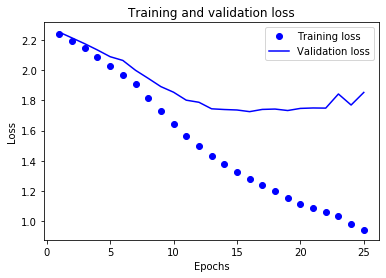

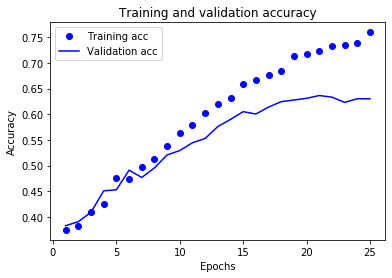

In [113]:
history_dict = history.history #A partir del objeto hystory lo guardamos para graficarlo
history_dict.keys()
#%matplotlib inline

acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

#bo is for blue dot
plt.plot(epochs, loss, 'bo', label='Training loss')
#b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

#bo is for blue dot
plt.plot(epochs, acc, 'bo', label='Training acc')
#b is for solid blue line
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [188]:
#la forma de entrada es el recuento de vocabulario utilizado para las reseñas de películas
vocab_size = 50000

model = keras.Sequential()
#una capa de embedding de los 10000 que tenemos en el vocabulario con un tamaño de 16. 
#Por cada elemento de entrada nos de un word embedding de 16 elementos. 
#256 vectores de 16 elementos 

model.add(keras.layers.Embedding(vocab_size, 32)) 
#Como son muchos elementos vamos a crear la medio de los word_embeddings

#Ahora si, una capa densa con relu

model.add(keras.layers.LSTM(40,return_sequences = True))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(50, activation=tf.nn.relu))
#Una última capa que tiene 1 elemento. La sigmoid se identifica más con una probabilidad.
model.add(keras.layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, None, 32)          1600000   
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 40)          11680     
_________________________________________________________________
global_average_pooling1d_24  (None, 40)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 50)                2050      
_________________________________________________________________
dense_47 (Dense)             (None, 46)                2346      
Total params: 1,616,076
Trainable params: 1,616,076
Non-trainable params: 0
_________________________________________________________________


In [189]:
model.compile(optimizer='adam', 
             loss='sparse_categorical_crossentropy', #la misma función de pérdida que CategoricalCrossentropy pero para problemas de dos clases
             metrics=['accuracy'])

In [190]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=64, 
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 1797 samples, validate on 7185 samples
Epoch 1/40
1797/1797 [==============================] - 14s 8ms/sample - loss: 3.5009 - accuracy: 0.3317 - val_loss: 2.8628 - val_accuracy: 0.3534
Epoch 2/40
1797/1797 [==============================] - 12s 7ms/sample - loss: 2.6206 - accuracy: 0.3450 - val_loss: 2.4611 - val_accuracy: 0.3534
Epoch 3/40
1797/1797 [==============================] - 12s 7ms/sample - loss: 2.3314 - accuracy: 0.3506 - val_loss: 2.3039 - val_accuracy: 0.3577
Epoch 4/40
1797/1797 [==============================] - 12s 7ms/sample - loss: 2.2332 - accuracy: 0.3511 - val_loss: 2.2510 - val_accuracy: 0.3591
Epoch 5/40
1797/1797 [==============================] - 12s 7ms/sample - loss: 2.1811 - accuracy: 0.3511 - val_loss: 2.2153 - val_accuracy: 0.3577
Epoch 6/40
1797/1797 [==============================] - 12s 7ms/sample - loss: 2.0857 - accuracy: 0.3645 - val_loss: 2.1375 - val_accuracy: 0.3724
Epoch 7/40
1797/1797 [==============================] - 12s 7ms/sample

In [191]:
results = model.evaluate(test_data, test_labels)
print(results)

2246/2246 [==============================] - 3s 1ms/sample - loss: 1.8630 - accuracy: 0.5111
[1.8629795451941282, 0.5111309]


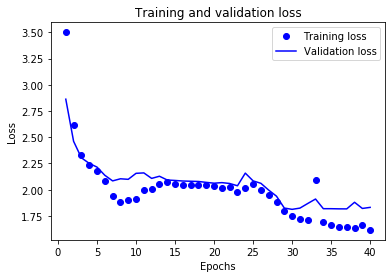

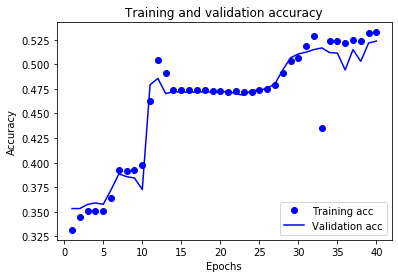

In [192]:
history_dict = history.history #A partir del objeto hystory lo guardamos para graficarlo
history_dict.keys()
#%matplotlib inline

acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

#bo is for blue dot
plt.plot(epochs, loss, 'bo', label='Training loss')
#b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

#bo is for blue dot
plt.plot(epochs, acc, 'bo', label='Training acc')
#b is for solid blue line
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()